In [1]:
import plotting as plotting

import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp

from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib

In [2]:
plt.rcParams['font.size'] = 24

In [3]:
result_dir = 'results/'
plot_dir = 'plots/'
data_dir = 'data/'
window_size = 60000
stride = window_size
detection_method = 'idt'
bac_threshold = 0.0
data_sources = ['pupilcore', 'eyelink']
data_source_names = ['wearable', 'remote']
feature_sets = ['all']
feature_set_names = ['All features']
my_pal = {'All features':'#1f77b4',
          'W/O pupil features':'#ff7f0e',
          'W/O closure feature':'#2ca02c',
          'Only eye movements':'#d62728',
          'Only pupil features':'#9467bd',
          'Only closure features':'#8c564b'}
group_variables = ['trial', 'subject',]
group_variable_names = ['Closed population', 'Open population',]
decimals = 3
use_metric = 'aucs_instance'
if use_metric == 'aucs_instance':
    fpr = 'fpr_instance'
    tpr = 'tpr_instance'
elif use_metric == 'aucs_subject':
    fpr = 'fpr_subject'
    tpr = 'tpr_subject'
bac_levels = np.arange(0,0.045,0.005)

Closed population
    BAC 0.0 positive instances: 954 positive subjects: 55
    BAC 0.005 positive instances: 945 positive subjects: 55
    BAC 0.01 positive instances: 935 positive subjects: 55
    BAC 0.015 positive instances: 901 positive subjects: 55
    BAC 0.02 positive instances: 834 positive subjects: 54
    BAC 0.025 positive instances: 754 positive subjects: 52
    BAC 0.03 positive instances: 593 positive subjects: 49
    BAC 0.035 positive instances: 458 positive subjects: 44
    BAC 0.04 positive instances: 206 positive subjects: 30
Open population
    BAC 0.0 positive instances: 954 positive subjects: 55
    BAC 0.005 positive instances: 945 positive subjects: 55
    BAC 0.01 positive instances: 935 positive subjects: 55
    BAC 0.015 positive instances: 901 positive subjects: 55
    BAC 0.02 positive instances: 834 positive subjects: 54
    BAC 0.025 positive instances: 754 positive subjects: 52
    BAC 0.03 positive instances: 593 positive subjects: 49
    BAC 0.035 pos

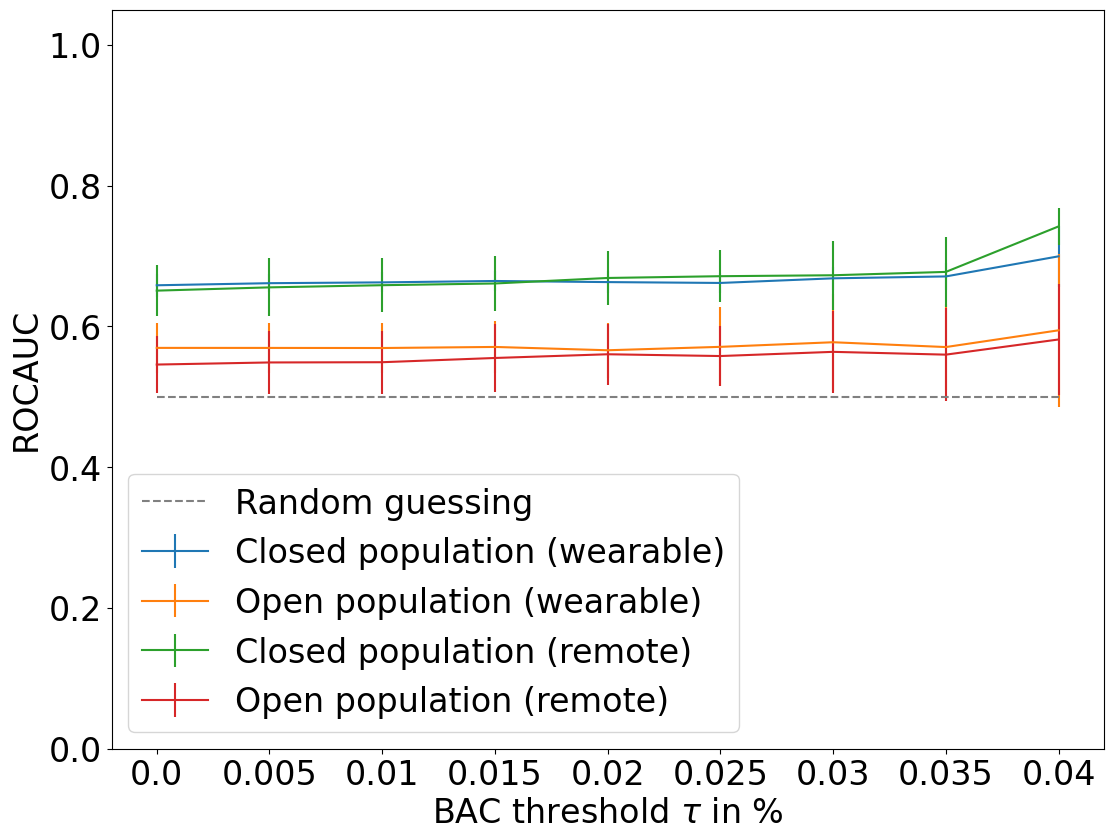

In [4]:
scale_factor = 2
plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
for i in range(len(data_sources)):
    data_source = data_sources[i]
    data_source_name = data_source_names[i]
    for j in range(len(group_variables)):
        cur_feature = feature_sets[0]
        group_variable = group_variables[j]
        group_variable_name = group_variable_names[j]
        print(group_variable_name)
        detection_string = plotting.get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)

        
        num_folds = len(cur_data['fold_dicts'])
        auc_matrix = np.zeros([len(bac_levels), num_folds])
        
        for b_i in range(len(bac_levels)):
            bac_level = bac_levels[b_i]
            sum_pos_ids = 0
            pos_subs = []
            for fold_i in range(num_folds):
                cur_fold_data = cur_data['fold_dicts'][fold_i]
                neg_ids = np.where(cur_fold_data['y_test_bac'] == 0)[0]
                pos_ids = np.where(cur_fold_data['y_test_bac'] > bac_level)[0]
                use_ids = np.concatenate([neg_ids, pos_ids])
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][use_ids], cur_fold_data['predictions'][use_ids], pos_label=1)
                auc = metrics.auc(fpr, tpr)
                auc_matrix[b_i, fold_i] = auc
                sum_pos_ids += len(pos_ids)
                pos_subs += list(np.unique(cur_fold_data['subjects_test'][pos_ids]))
            sum_pos_sub = len(np.unique(pos_subs))
            print('    BAC ' + str(bac_level) + ' positive instances: ' + str(sum_pos_ids) + ' positive subjects: ' + str(sum_pos_sub))
        plt.errorbar(np.arange(len(bac_levels)), np.nanmean(auc_matrix, axis=1), np.nanstd(auc_matrix, axis=1),
                    label=group_variable_name + ' (' + data_source_name + ')')
plt.plot(np.arange(len(bac_levels)),[0.5 for _ in np.arange(len(bac_levels))], color='grey', linestyle='dashed',
             label='Random guessing')
plt.xlabel('BAC threshold $\\tau$ in %')
plt.ylabel('ROCAUC')
plt.xticks(np.arange(len(bac_levels)),bac_levels)
plt.legend(ncols=1)
plt.ylim([0.0,1.05])
plt.savefig(plot_dir + 'bac_levels.pdf', dpi=300)
plt.show()

Closed population
Open population
Closed population
Open population


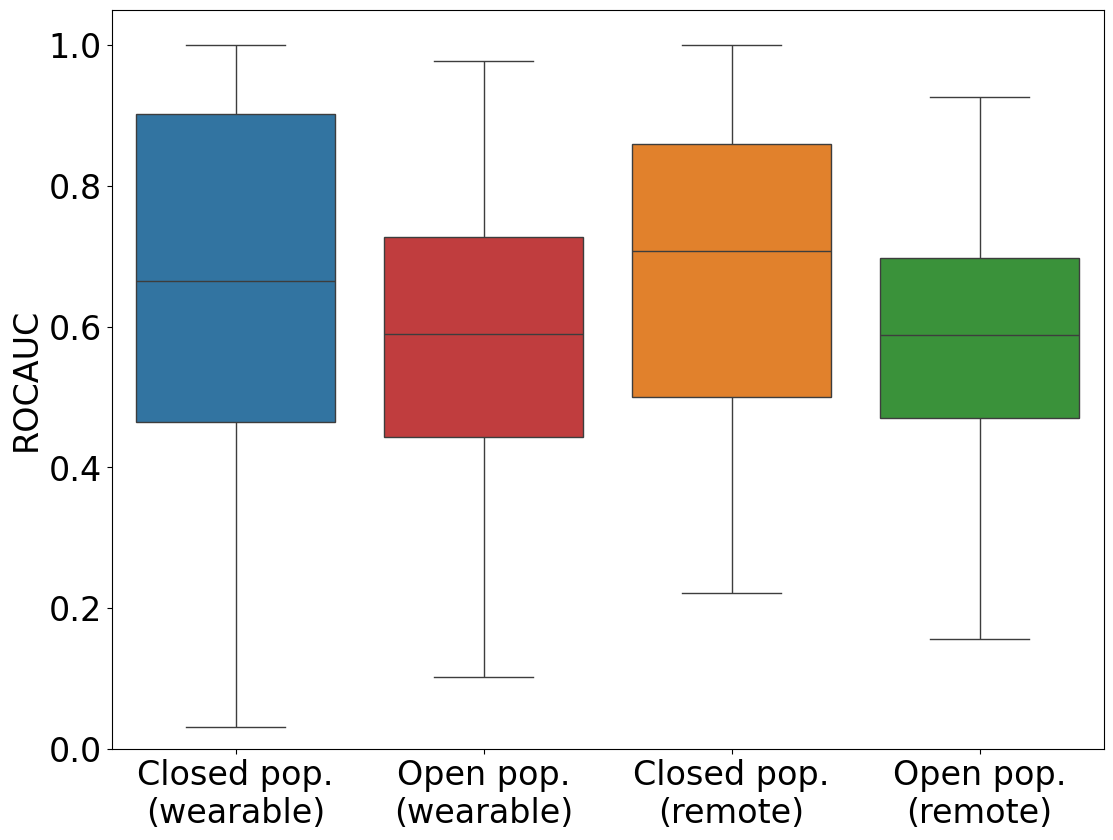

In [5]:
scale_factor = 2
plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
auc_values = []
feature_values = []
for i in range(len(data_sources)):
    data_source = data_sources[i]
    data_source_name = data_source_names[i]
    for j in range(len(group_variables)):
        cur_feature = feature_sets[0]
        group_variable = group_variables[j]
        group_variable_name = group_variable_names[j]
        print(group_variable_name)
        detection_string = plotting.get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)
        num_folds = len(cur_data['fold_dicts'])
        
        subject_aucs = []
        for fold_i in range(num_folds):
            cur_fold_data = cur_data['fold_dicts'][fold_i]
            fold_subjects = cur_fold_data['subjects_test']
            unique_subjects = list(np.unique(fold_subjects))
            for s_i in range(len(unique_subjects)):
                c_subject = unique_subjects[s_i]
                c_ids = np.where(np.array(fold_subjects) == c_subject)[0]
                if len(np.unique(cur_fold_data['y_test'][c_ids])) == 1:
                    continue
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][c_ids], cur_fold_data['predictions'][c_ids], pos_label=1)
                auc = np.float32(metrics.auc(fpr, tpr))
                subject_aucs.append(auc)
                auc_values.append(auc)
                feature_values.append(group_variable_name.replace('population','pop.') + '\n(' + data_source_name + ')')

setting_pal = {'Closed pop.\n(wearable)':'#1f77b4',
                'Closed pop.\n(remote)':'#ff7f0e',
                'Open pop.\n(remote)':'#2ca02c',
                'Open pop.\n(wearable)':'#d62728',}

box_data = pl.DataFrame({'ROCAUC': auc_values,
                             'Setting': feature_values})
sns.boxplot(box_data,x='Setting', y = 'ROCAUC', hue='Setting', palette=setting_pal, legend=False)
#sns.boxplot(hue=box_data['Setting'], y=box_data['ROCAUC'], gap=0.1)#, palette=my_pal, gap=0.1)
#plt.ylim([0,1.65])
plt.ylim([0,1.05])
plt.yticks([0,0.2,0.4,0.6,0.8,1.])
plt.xlabel('')
plt.savefig(plot_dir + 'box_subject_aucs.pdf', dpi=300)
plt.show()